In [204]:
#Install Dependencies
import pandas as pd
from pathlib import Path
import re

pd.set_option('display.max_columns',50)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

!pip install openmeteo-requests

!pip install requests-cache retry-requests numpy pandas


import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, GridSearchCV
import joblib

In [65]:
#Import CSV's

austin_ride_df = pd.read_csv('https://raw.githubusercontent.com/jchay3/james_hay_project_2_Compare_ride_patterns_and_predictive_modeling_of_rides_by-_transport_x/main/Austin%20Ride%20data%20without%20customer%20info.csv')


In [66]:
#Display Data
austin_ride_df.head()


,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles
0,555803,Vincent Iyamu,Ride Now,A,Vincent Iyamu,West Campus,NaN,Downtown,Charles Alan Wright Fields at the Berry M. Whi...,NaN,03/04/2025 08:22 PM (CST),03/04/2025 08:35 PM (CST),8186011505,Completed,NaN,NaN,0.0,0,0,0,0,52.47,2.44
1,555764,Vincent Iyamu,Scheduled,B,Vincent Iyamu,Convention Center District,Radius 1,Downtown,The Callaway House Austin,Downtown,03/04/2025 07:23 PM (CST),03/04/2025 07:35 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,57.10,2.13
2,555733,Ero Ohiro (AVS),Ride Now,A,Ero Ohiro,West Campus,NaN,Downtown,Shoal Creek Saloon,Downtown,03/04/2025 05:56 PM (CST),03/04/2025 06:03 PM (CST),5127572824,Completed,NaN,NaN,0.0,0,0,0,0,32.28,1.39
3,555726,Vincent Iyamu,Scheduled,A,Vincent Iyamu,The Callaway House Austin,Radius 1,Downtown,The Escape Game Austin,Downtown,03/04/2025 05:45 PM (CST),03/04/2025 06:06 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,62.92,2.16
4,555648,Philisani Dlamini (TRANSPORT),Ride Now,A,Philisani Dlamini,Rosedale,NaN,Downtown,Villas on Rio,Downtown,03/03/2025 09:24 PM (CST),03/03/2025 09:33 PM (CST),4698345054,Completed,NaN,NaN,0.0,0,0,0,0,82.60,2.60


In [67]:
#Import Weather data


In [68]:
#set up API Client
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [69]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
locations = [
	(30.2672, -97.7431), # Austin, Tx
    (30.4433, -91.1875), # Baton Rouge, LA
    (33.749, -84.388) # Atlanta, GA
]

url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 30.2672,
	"longitude": -97.7431,
	"start_date": "2023-12-31",
	"end_date": "2025-03-01",
	"hourly": ["temperature_2m", "precipitation", "rain", "snowfall", "cloud_cover", "wind_speed_10m"],
	"timezone": "America/Chicago"
}
responses = openmeteo.weather_api(url, params=params)

In [70]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")


Coordinates 30.26361846923828°N -97.69320678710938°E
Elevation 157.0 m asl
Timezone b'America/Chicago' b'GMT-5'
Timezone difference to GMT+0 -18000 s


In [71]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(1).ValuesAsNumpy()
hourly_rain = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
hourly_cloud_cover = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()


hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["precipitation"] = hourly_precipitation
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["cloud_cover"] = hourly_cloud_cover
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m


austin_hourly_dataframe = pd.DataFrame(data = hourly_data)
print(austin_hourly_dataframe)

                           date  temperature_2m  precipitation  rain  \
0     2023-12-31 05:00:00+00:00       10.658501            0.0   0.0   
1     2023-12-31 06:00:00+00:00       10.258500            0.0   0.0   
2     2023-12-31 07:00:00+00:00        9.908501            0.0   0.0   
3     2023-12-31 08:00:00+00:00        9.308500            0.0   0.0   
4     2023-12-31 09:00:00+00:00        8.508500            0.0   0.0   
...                         ...             ...            ...   ...   
10243 2025-03-02 00:00:00+00:00       24.258501            0.0   0.0   
10244 2025-03-02 01:00:00+00:00       23.708500            0.0   0.0   
10245 2025-03-02 02:00:00+00:00       22.858500            0.0   0.0   
10246 2025-03-02 03:00:00+00:00       21.308500            0.0   0.0   
10247 2025-03-02 04:00:00+00:00       19.808500            0.0   0.0   

       snowfall  cloud_cover  wind_speed_10m  
0           0.0         99.0       11.525623  
1           0.0         98.0       11.525

In [72]:
austin_hourly_dataframe.head(5)

,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m
0,2023-12-31 05:00:00+00:00,10.658501,0.0,0.0,0.0,99.0,11.525623
1,2023-12-31 06:00:00+00:00,10.258500,0.0,0.0,0.0,98.0,11.525623
2,2023-12-31 07:00:00+00:00,9.908501,0.0,0.0,0.0,100.0,11.753876
3,2023-12-31 08:00:00+00:00,9.308500,0.0,0.0,0.0,100.0,10.383987
4,2023-12-31 09:00:00+00:00,8.508500,0.0,0.0,0.0,99.0,9.693296


In [73]:
#Confirm we have data up until march 1 2025
austin_hourly_dataframe.tail(20)

,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m
10228,2025-03-01 09:00:00+00:00,12.258500,0.0,0.0,0.0,0.0,5.483356
10229,2025-03-01 10:00:00+00:00,11.908501,0.0,0.0,0.0,0.0,6.034700
10230,2025-03-01 11:00:00+00:00,11.208500,0.0,0.0,0.0,7.0,5.411986
10231,2025-03-01 12:00:00+00:00,11.008500,0.0,0.0,0.0,1.0,6.287130
10232,2025-03-01 13:00:00+00:00,9.758500,0.0,0.0,0.0,0.0,7.380000
10233,2025-03-01 14:00:00+00:00,11.358500,0.0,0.0,0.0,33.0,8.258451
10234,2025-03-01 15:00:00+00:00,14.858500,0.0,0.0,0.0,43.0,4.829907
10235,2025-03-01 16:00:00+00:00,18.908501,0.0,0.0,0.0,4.0,3.947708
10236,2025-03-01 17:00:00+00:00,22.458500,0.0,0.0,0.0,0.0,3.189608
10237,2025-03-01 18:00:00+00:00,24.908501,0.0,0.0,0.0,13.0,2.675892


In [74]:
austin_hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248 entries, 0 to 10247
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   date            10248 non-null  datetime64[ns, UTC]
 1   temperature_2m  10248 non-null  float32            
 2   precipitation   10248 non-null  float32            
 3   rain            10248 non-null  float32            
 4   snowfall        10248 non-null  float32            
 5   cloud_cover     10248 non-null  float32            
 6   wind_speed_10m  10248 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(6)
memory usage: 320.4 KB


In [75]:
#Import Weather forecasts


# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [76]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://api.open-meteo.com/v1/forecast"
params = {
	"latitude": 30.2672,
	"longitude": -97.7431,
	"hourly": ["temperature_2m", "rain", "showers", "snowfall", "precipitation", "precipitation_probability", "wind_speed_10m"],
	"timezone": "America/Chicago",
	"forecast_days": 14
}

In [77]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")


Coordinates 30.26361846923828°N -97.69320678710938°E
Elevation 157.0 m asl
Timezone b'America/Chicago'b'GMT-5'
Timezone difference to GMT+0 -18000 s


In [78]:
# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_rain = hourly.Variables(1).ValuesAsNumpy()
hourly_showers = hourly.Variables(2).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(3).ValuesAsNumpy()
hourly_precipitation = hourly.Variables(4).ValuesAsNumpy()


#hourly_wind_speed_10m = hourly.Variables(6).ValuesAsNumpy()

In [79]:
hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["rain"] = hourly_rain
hourly_data["showers"] = hourly_showers
hourly_data["snowfall"] = hourly_snowfall
hourly_data["precipitation"] = hourly_precipitation
hourly_data["precipitation_probability"] = hourly_precipitation_probability
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m



In [80]:
#Create DF for forecast
austin_forcast_df = pd.DataFrame(data = hourly_data)
print(austin_forcast_df)

                           date  temperature_2m  rain  showers  snowfall  \
0     2023-12-31 05:00:00+00:00       10.658501   0.0      0.0       0.0   
1     2023-12-31 06:00:00+00:00       10.258500   0.0      0.0       0.0   
2     2023-12-31 07:00:00+00:00        9.908501   0.0      0.0       0.0   
3     2023-12-31 08:00:00+00:00        9.308500   0.0      0.0       0.0   
4     2023-12-31 09:00:00+00:00        8.508500   0.0      0.0       0.0   
...                         ...             ...   ...      ...       ...   
10243 2025-03-02 00:00:00+00:00       24.258501   0.0      0.0       0.0   
10244 2025-03-02 01:00:00+00:00       23.708500   0.0      0.0       0.0   
10245 2025-03-02 02:00:00+00:00       22.858500   0.0      0.0       0.0   
10246 2025-03-02 03:00:00+00:00       21.308500   0.0      0.0       0.0   
10247 2025-03-02 04:00:00+00:00       19.808500   0.0      0.0       0.0   

       precipitation  precipitation_probability  wind_speed_10m  
0               99.0 

In [81]:
#Explore value types

austin_ride_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7449 entries, 0 to 7448
Data columns (total 23 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   ride_id                                                     7449 non-null   int64  
 1   vehicle_number                                              7449 non-null   object 
 2   ride_type                                                   7449 non-null   object 
 3   proximity                                                   7335 non-null   object 
 4   driver_name                                                 7449 non-null   object 
 5   pickup                                                      7449 non-null   object 
 6   radius_schedule_pickup_dispatch_text                        1379 non-null   object 
 7   pickup_driver_zone                                          4538 non-null   object 
 8 

In [82]:
#Use Regex to remove CST from the orginal Ride Start time
austin_ride_df['ride_start_date_time_cleaned'] = austin_ride_df['ride_start_date_time'].str.replace(r'\s*\([A-Z]+\)', '', regex=True)
austin_ride_df['ride_end_date_time_cleaned'] = austin_ride_df['ride_end_date_time'].str.replace(r'\s*\([A-Z]+\)', '', regex=True)

austin_ride_df['ride_start_date_time_converted'] = pd.to_datetime(austin_ride_df['ride_start_date_time_cleaned'], format='%m/%d/%Y %I:%M %p')
austin_ride_df['ride_end_date_time_converted'] = pd.to_datetime(austin_ride_df['ride_end_date_time_cleaned'], format='%m/%d/%Y %I:%M %p')

austin_ride_df

,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles,ride_start_date_time_cleaned,ride_end_date_time_cleaned,ride_start_date_time_converted,ride_end_date_time_converted
0,555803,Vincent Iyamu,Ride Now,A,Vincent Iyamu,West Campus,NaN,Downtown,Charles Alan Wright Fields at the Berry M. Whi...,NaN,03/04/2025 08:22 PM (CST),03/04/2025 08:35 PM (CST),8186011505,Completed,NaN,NaN,0.0,0,0,0,0,52.47,2.44,03/04/2025 08:22 PM,03/04/2025 08:35 PM,2025-03-04 20:22:00,2025-03-04 20:35:00
1,555764,Vincent Iyamu,Scheduled,B,Vincent Iyamu,Convention Center District,Radius 1,Downtown,The Callaway House Austin,Downtown,03/04/2025 07:23 PM (CST),03/04/2025 07:35 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,57.10,2.13,03/04/2025 07:23 PM,03/04/2025 07:35 PM,2025-03-04 19:23:00,2025-03-04 19:35:00
2,555733,Ero Ohiro (AVS),Ride Now,A,Ero Ohiro,West Campus,NaN,Downtown,Shoal Creek Saloon,Downtown,03/04/2025 05:56 PM (CST),03/04/2025 06:03 PM (CST),5127572824,Completed,NaN,NaN,0.0,0,0,0,0,32.28,1.39,03/04/2025 05:56 PM,03/04/2025 06:03 PM,2025-03-04 17:56:00,2025-03-04 18:03:00
3,555726,Vincent Iyamu,Scheduled,A,Vincent Iyamu,The Callaway House Austin,Radius 1,Downtown,The Escape Game Austin,Downtown,03/04/2025 05:45 PM (CST),03/04/2025 06:06 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,62.92,2.16,03/04/2025 05:45 PM,03/04/2025 06:06 PM,2025-03-04 17:45:00,2025-03-04 18:06:00
4,555648,Philisani Dlamini (TRANSPORT),Ride Now,A,Philisani Dlamini,Rosedale,NaN,Downtown,Villas on Rio,Downtown,03/03/2025 09:24 PM (CST),03/03/2025 09:33 PM (CST),4698345054,Completed,NaN,NaN,0.0,0,0,0,0,82.60,2.60,03/03/2025 09:24 PM,03/03/2025 09:33 PM,2025-03-03 21:24:00,2025-03-03 21:33:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,252966,Bankole O (T-ATX),Ride Now,C,Bankole Okunbolade,Market District,NaN,Downtown,Moontower,Downtown,01/01/2024 01:55 AM (CST),01/01/2024 02:00 AM (CST),7133761730,Completed,NaN,NaN,0.0,0,0,0,0,77.99,1.41,01/01/2024 01:55 AM,01/01/2024 02:00 AM,2024-01-01 01:55:00,2024-01-01 02:00:00
7445,252979,Charles U (APEX),Ride Now,BB,Charles Mondia,Bouldin Creek,NaN,Downtown,1301 Crossing Place,NaN,01/01/2024 01:50 AM (CST),01/01/2024 02:00 AM (CST),2143649757,Completed,NaN,NaN,0.0,0,0,0,0,56.28,3.35,01/01/2024 01:50 AM,01/01/2024 02:00 AM,2024-01-01 01:50:00,2024-01-01 02:00:00
7446,252917,Charles U (APEX),Ride Now,A,Charles Mondia,Convention Center District,NaN,Downtown,4521 Merle Drive,NaN,01/01/2024 01:21 AM (CST),01/01/2024 01:34 AM (CST),2143009827,Completed,NaN,NaN,0.0,0,0,0,0,96.24,6.41,01/01/2024 01:21 AM,01/01/2024 01:34 AM,2024-01-01 01:21:00,2024-01-01 01:34:00
7447,252865,Gustavo Vehicle,Ride Now,BB,Gustavo Ortlieb,South Congress,NaN,NaN,The Bowie,Downtown,01/01/2024 01:00 AM (CST),01/01/2024 01:29 AM (CST),6264049796,Completed,NaN,NaN,0.0,0,0,0,1,52.15,2.03,01/01/2024 01:00 AM,01/01/2024 01:29 AM,2024-01-01 01:00:00,2024-01-01 01:29:00


In [83]:
#Convert weathher time to match converted time of Ride info 

austin_hourly_dataframe['date_converted'] = (
    pd.to_datetime(austin_hourly_dataframe['date'], format='%m/%d/%Y %I:%M %p')
    .dt.tz_localize(None)
)
austin_hourly_dataframe


,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,date_converted
0,2023-12-31 05:00:00+00:00,10.658501,0.0,0.0,0.0,99.0,11.525623,2023-12-31 05:00:00
1,2023-12-31 06:00:00+00:00,10.258500,0.0,0.0,0.0,98.0,11.525623,2023-12-31 06:00:00
2,2023-12-31 07:00:00+00:00,9.908501,0.0,0.0,0.0,100.0,11.753876,2023-12-31 07:00:00
3,2023-12-31 08:00:00+00:00,9.308500,0.0,0.0,0.0,100.0,10.383987,2023-12-31 08:00:00
4,2023-12-31 09:00:00+00:00,8.508500,0.0,0.0,0.0,99.0,9.693296,2023-12-31 09:00:00
...,...,...,...,...,...,...,...,...
10243,2025-03-02 00:00:00+00:00,24.258501,0.0,0.0,0.0,51.0,8.827344,2025-03-02 00:00:00
10244,2025-03-02 01:00:00+00:00,23.708500,0.0,0.0,0.0,100.0,9.807935,2025-03-02 01:00:00
10245,2025-03-02 02:00:00+00:00,22.858500,0.0,0.0,0.0,100.0,10.692969,2025-03-02 02:00:00
10246,2025-03-02 03:00:00+00:00,21.308500,0.0,0.0,0.0,100.0,8.197414,2025-03-02 03:00:00


In [84]:
# Merge on the ride start time with weather data for that time
austin_merged_data = pd.merge_asof(
    austin_ride_df.sort_values('ride_start_date_time_converted'), 
    austin_hourly_dataframe.sort_values('date_converted'), 
    left_on='ride_start_date_time_converted', 
    right_on='date_converted', 
    direction='backward'  
)

austin_merged_data

,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles,ride_start_date_time_cleaned,ride_end_date_time_cleaned,ride_start_date_time_converted,ride_end_date_time_converted,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,date_converted
0,252846,Bankole O (T-ATX),Ride Now,C,Bankole Okunbolade,South Austin,NaN,NaN,3850 Burnham,NaN,01/01/2024 12:48 AM (CST),01/01/2024 01:00 AM (CST),2542293800,Completed,NaN,NaN,0.0,0,0,1,0,93.84,11.96,01/01/2024 12:48 AM,01/01/2024 01:00 AM,2024-01-01 00:48:00,2024-01-01 01:00:00,2024-01-01 00:00:00+00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,2024-01-01 00:00:00
1,252865,Gustavo Vehicle,Ride Now,BB,Gustavo Ortlieb,South Congress,NaN,NaN,The Bowie,Downtown,01/01/2024 01:00 AM (CST),01/01/2024 01:29 AM (CST),6264049796,Completed,NaN,NaN,0.0,0,0,0,1,52.15,2.03,01/01/2024 01:00 AM,01/01/2024 01:29 AM,2024-01-01 01:00:00,2024-01-01 01:29:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00
2,252917,Charles U (APEX),Ride Now,A,Charles Mondia,Convention Center District,NaN,Downtown,4521 Merle Drive,NaN,01/01/2024 01:21 AM (CST),01/01/2024 01:34 AM (CST),2143009827,Completed,NaN,NaN,0.0,0,0,0,0,96.24,6.41,01/01/2024 01:21 AM,01/01/2024 01:34 AM,2024-01-01 01:21:00,2024-01-01 01:34:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00
3,252979,Charles U (APEX),Ride Now,BB,Charles Mondia,Bouldin Creek,NaN,Downtown,1301 Crossing Place,NaN,01/01/2024 01:50 AM (CST),01/01/2024 02:00 AM (CST),2143649757,Completed,NaN,NaN,0.0,0,0,0,0,56.28,3.35,01/01/2024 01:50 AM,01/01/2024 02:00 AM,2024-01-01 01:50:00,2024-01-01 02:00:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00
4,252966,Bankole O (T-ATX),Ride Now,C,Bankole Okunbolade,Market District,NaN,Downtown,Moontower,Downtown,01/01/2024 01:55 AM (CST),01/01/2024 02:00 AM (CST),7133761730,Completed,NaN,NaN,0.0,0,0,0,0,77.99,1.41,01/01/2024 01:55 AM,01/01/2024 02:00 AM,2024-01-01 01:55:00,2024-01-01 02:00:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,555648,Philisani Dlamini (TRANSPORT),Ride Now,A,Philisani Dlamini,Rosedale,NaN,Downtown,Villas on Rio,Downtown,03/03/2025 09:24 PM (CST),03/03/2025 09:33 PM (CST),4698345054,Completed,NaN,NaN,0.0,0,0,0,0,82.60,2.60,03/03/2025 09:24 PM,03/03/2025 09:33 PM,2025-03-03 21:24:00,2025-03-03 21:33:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00
7445,555726,Vincent Iyamu,Scheduled,A,Vincent Iyamu,The Callaway House Austin,Radius 1,Downtown,The Escape Game Austin,Downtown,03/04/2025 05:45 PM (CST),03/04/2025 06:06 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,62.92,2.16,03/04/2025 05:45 PM,03/04/2025 06:06 PM,2025-03-04 17:45:00,2025-03-04 18:06:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00
7446,555733,Ero Ohiro (AVS),Ride Now,A,Ero Ohiro,West Campus,NaN,Downtown,Shoal Creek Saloon,Downtown,03/04/2025 05:56 PM (CST),03/04/2025 06:03 PM (CST),5127572824,Completed,NaN,NaN,0.0,0,0,0,0,32.28,1.39,03/04/2025 05:56 PM,03/04/2025 06:03 PM,2025-03-04 17:56:00,2025-03-04 18:03:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00
7447,555764,Vincent Iyamu,Scheduled,B,Vincent Iyamu,Convention Center District,Radius 1,Downtown,The Callaway House Austin,Downtown,03/04/2025 07:23 PM (CST),03/04/2025 07:35 PM (CST),2246320212,Completed,NaN,Na

In [85]:
#Create a funnction that produces a ride time column by figuring out difference between start and end times of rides

def calculate_ride_duration(start_time, end_time):
    return (end_time - start_time).total_seconds() / 60

austin_merged_data['total_ride_time_minutes'] = austin_merged_data.apply(
    lambda row: calculate_ride_duration(row['ride_start_date_time_converted'], row['ride_end_date_time_converted']), axis=1
)

print(austin_merged_data[['ride_start_date_time_converted', 'ride_end_date_time_converted', 'total_ride_time_minutes']].head())


  ride_start_date_time_converted ride_end_date_time_converted  \
0            2024-01-01 00:48:00          2024-01-01 01:00:00   
1            2024-01-01 01:00:00          2024-01-01 01:29:00   
2            2024-01-01 01:21:00          2024-01-01 01:34:00   
3            2024-01-01 01:50:00          2024-01-01 02:00:00   
4            2024-01-01 01:55:00          2024-01-01 02:00:00   

   total_ride_time_minutes  
0                     12.0  
1                     29.0  
2                     13.0  
3                     10.0  
4                      5.0  


In [86]:
austin_merged_data

,ride_id,vehicle_number,ride_type,proximity,driver_name,pickup,radius_schedule_pickup_dispatch_text,pickup_driver_zone,departure,dropoff_driver_zone,ride_start_date_time,ride_end_date_time,customer_mobile,ride_status,allow_start_ride_at,allow_start_ride_description,long_distance_pickup_fee,long_distance_pickup_min_passengers,checkedin_passengers_after_finish_boarding_confirmed_count,age_surge_charge,is_rescan_data_available,total_revenue,ride_miles,ride_start_date_time_cleaned,ride_end_date_time_cleaned,ride_start_date_time_converted,ride_end_date_time_converted,date,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,date_converted,total_ride_time_minutes
0,252846,Bankole O (T-ATX),Ride Now,C,Bankole Okunbolade,South Austin,NaN,NaN,3850 Burnham,NaN,01/01/2024 12:48 AM (CST),01/01/2024 01:00 AM (CST),2542293800,Completed,NaN,NaN,0.0,0,0,1,0,93.84,11.96,01/01/2024 12:48 AM,01/01/2024 01:00 AM,2024-01-01 00:48:00,2024-01-01 01:00:00,2024-01-01 00:00:00+00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,2024-01-01 00:00:00,12.0
1,252865,Gustavo Vehicle,Ride Now,BB,Gustavo Ortlieb,South Congress,NaN,NaN,The Bowie,Downtown,01/01/2024 01:00 AM (CST),01/01/2024 01:29 AM (CST),6264049796,Completed,NaN,NaN,0.0,0,0,0,1,52.15,2.03,01/01/2024 01:00 AM,01/01/2024 01:29 AM,2024-01-01 01:00:00,2024-01-01 01:29:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00,29.0
2,252917,Charles U (APEX),Ride Now,A,Charles Mondia,Convention Center District,NaN,Downtown,4521 Merle Drive,NaN,01/01/2024 01:21 AM (CST),01/01/2024 01:34 AM (CST),2143009827,Completed,NaN,NaN,0.0,0,0,0,0,96.24,6.41,01/01/2024 01:21 AM,01/01/2024 01:34 AM,2024-01-01 01:21:00,2024-01-01 01:34:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00,13.0
3,252979,Charles U (APEX),Ride Now,BB,Charles Mondia,Bouldin Creek,NaN,Downtown,1301 Crossing Place,NaN,01/01/2024 01:50 AM (CST),01/01/2024 02:00 AM (CST),2143649757,Completed,NaN,NaN,0.0,0,0,0,0,56.28,3.35,01/01/2024 01:50 AM,01/01/2024 02:00 AM,2024-01-01 01:50:00,2024-01-01 02:00:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00,10.0
4,252966,Bankole O (T-ATX),Ride Now,C,Bankole Okunbolade,Market District,NaN,Downtown,Moontower,Downtown,01/01/2024 01:55 AM (CST),01/01/2024 02:00 AM (CST),7133761730,Completed,NaN,NaN,0.0,0,0,0,0,77.99,1.41,01/01/2024 01:55 AM,01/01/2024 02:00 AM,2024-01-01 01:55:00,2024-01-01 02:00:00,2024-01-01 01:00:00+00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,2024-01-01 01:00:00,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,555648,Philisani Dlamini (TRANSPORT),Ride Now,A,Philisani Dlamini,Rosedale,NaN,Downtown,Villas on Rio,Downtown,03/03/2025 09:24 PM (CST),03/03/2025 09:33 PM (CST),4698345054,Completed,NaN,NaN,0.0,0,0,0,0,82.60,2.60,03/03/2025 09:24 PM,03/03/2025 09:33 PM,2025-03-03 21:24:00,2025-03-03 21:33:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00,9.0
7445,555726,Vincent Iyamu,Scheduled,A,Vincent Iyamu,The Callaway House Austin,Radius 1,Downtown,The Escape Game Austin,Downtown,03/04/2025 05:45 PM (CST),03/04/2025 06:06 PM (CST),2246320212,Completed,NaN,NaN,0.0,0,0,0,0,62.92,2.16,03/04/2025 05:45 PM,03/04/2025 06:06 PM,2025-03-04 17:45:00,2025-03-04 18:06:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00,21.0
7446,555733,Ero Ohiro (AVS),Ride Now,A,Ero Ohiro,West Campus,NaN,Downtown,Shoal Creek Saloon,Downtown,03/04/2025 05:56 PM (CST),03/04/2025 06:03 PM (CST),5127572824,Completed,NaN,NaN,0.0,0,0,0,0,32.28,1.39,03/04/2025 05:56 PM,03/04/2025 06:03 PM,2025-03-04 17:56:00,2025-03-04 18:03:00,2025-03-02 04:00:00+00:00,19.808500,0.0,0.0,0.0,100.0,8.375320,2025-03-02 04:00:00,7.0
7447,555764,Vincent Iyamu,Scheduled,B,Vincent Iyamu,Convention Center District,Radius 1,Downtown,The Callaway House Austin,Downtown,03/04/2025 07:

In [87]:
#drop unwanted columns and create a cleaned DF

columns_to_drop = [
    'ride_id', 'vehicle_number', 'ride_type', 'proximity', 'driver_name', 'pickup', 
    'radius_schedule_pickup_dispatch_text', 'pickup_driver_zone', 'departure', 
    'dropoff_driver_zone', 'ride_start_date_time', 'ride_end_date_time', 'customer_mobile', 
    'ride_status', 'allow_start_ride_at', 'allow_start_ride_description', 
    'long_distance_pickup_fee', 'long_distance_pickup_min_passengers', 
    'checkedin_passengers_after_finish_boarding_confirmed_count', 
    'is_rescan_data_available', 'ride_end_date_time_cleaned', 
    'ride_start_date_time_cleaned', 'date_converted', 'date', 
]

austin_cleaned = austin_merged_data.drop(columns=columns_to_drop)

austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,19.808500,0.0,0.0,0.0,100.0,8.375320,9.0
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,19.808500,0.0,0.0,0.0,100.0,8.375320,21.0
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,19.808500,0.0,0.0,0.0,100.0,8.375320,7.0
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,19.808500,0.0,0.0,0.0,100.0,8.375320,12.0


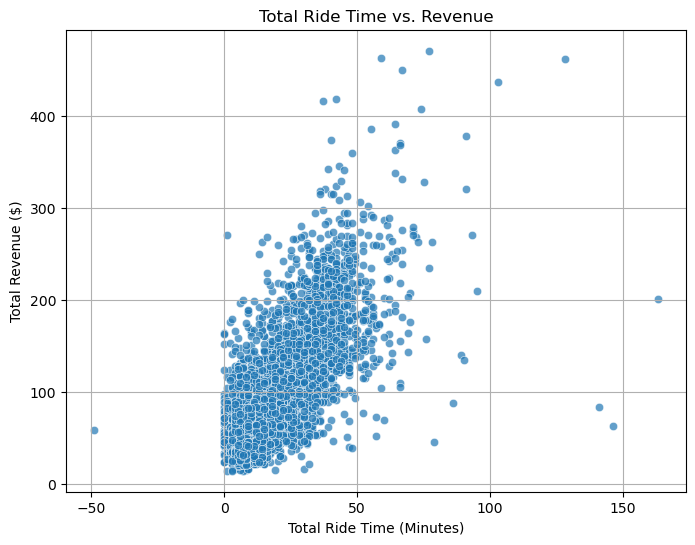

In [88]:
#Create a scatter plot to visualize ride times vs Revenue

plt.figure(figsize=(8, 6))
sns.scatterplot(data=austin_cleaned, x='total_ride_time_minutes', y='total_revenue', alpha=0.7)
plt.xlabel('Total Ride Time (Minutes)')
plt.ylabel('Total Revenue ($)')
plt.title('Total Ride Time vs. Revenue')
plt.grid(True)
plt.show()

C:\Users\jchay\AppData\Local\Temp\ipykernel_6832\4263301152.py:3: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_data = austin_cleaned.pivot_table(


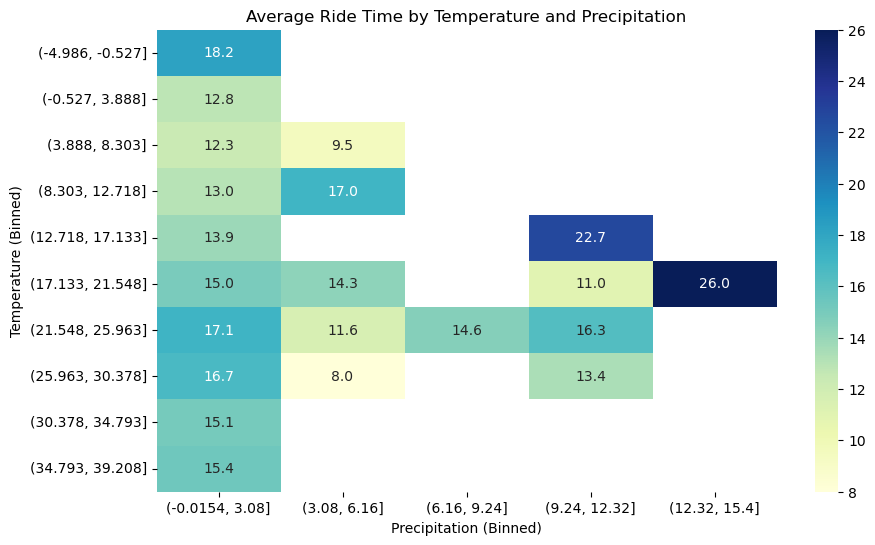

In [89]:
#create Heat map showing Average Ride time with percipatation and Temp

pivot_data = austin_cleaned.pivot_table(
    index=pd.cut(austin_cleaned['temperature_2m'], bins=10),
    columns=pd.cut(austin_cleaned['precipitation'], bins=5),
    values='total_ride_time_minutes',
    aggfunc='mean'
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.1f')
plt.xlabel('Precipitation (Binned)')
plt.ylabel('Temperature (Binned)')
plt.title('Average Ride Time by Temperature and Precipitation')
plt.show()

In [90]:
#Create usable precipitation categories

austin_cleaned['total_precipitation'] = austin_cleaned['rain'] + austin_cleaned['snowfall']

bins = [0, 0.5, 2, 5, np.inf]  
labels = ['None', 'Light', 'Medium', 'Heavy']

austin_cleaned['precipitation_category'] = pd.cut(austin_cleaned['total_precipitation'], bins=bins, labels=labels, right=False)
austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,None
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,None
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,None
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,None
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,19.808500,0.0,0.0,0.0,100.0,8.375320,9.0,0.0,None
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,19.808500,0.0,0.0,0.0,100.0,8.375320,21.0,0.0,None
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,19.808500,0.0,0.0,0.0,100.0,8.375320,7.0,0.0,None
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,19.808500,0.0,0.0,0.0,100.0,8.375320,12.0,0.0,None


In [91]:
#Apply a log transformation which can better help visualize this data since its often close to 0

austin_cleaned['log_total_precipitation'] = np.log1p(austin_cleaned['total_precipitation'])


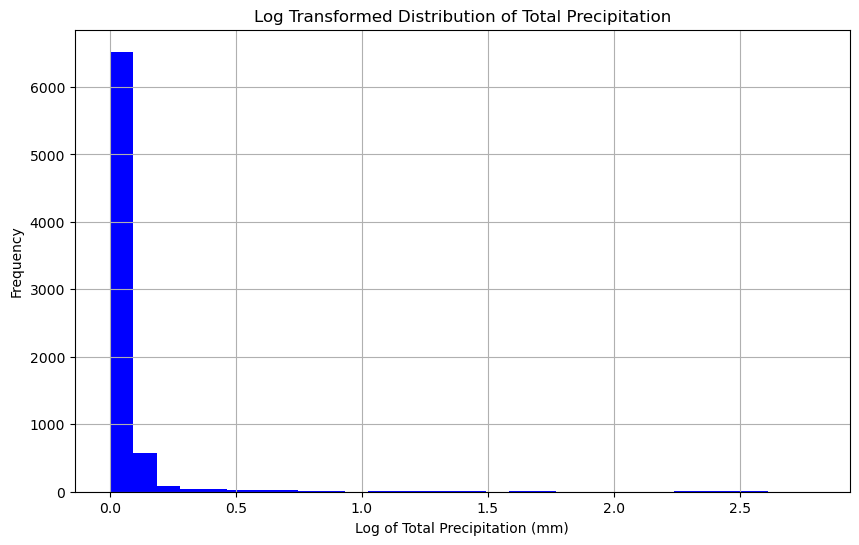

In [92]:
#Create the Graph 

plt.figure(figsize=(10, 6))
plt.hist(austin_cleaned['log_total_precipitation'], bins=30, color='blue')
plt.title('Log Transformed Distribution of Total Precipitation')
plt.xlabel('Log of Total Precipitation (mm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [93]:
print(austin_cleaned['log_total_precipitation'].describe())

count    7449.000000
mean        0.047537
std         0.224291
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.797281
Name: log_total_precipitation, dtype: float64


In [94]:
austin_cleaned['precipitation_category'].value_counts()

precipitation_category
None      7216
Light      140
Medium      63
Heavy       30
Name: count, dtype: int64

In [95]:
#Create a mean revenue for each Precipitation category

revenue_by_precipitation = austin_cleaned.groupby('precipitation_category')['total_revenue'].mean()
revenue_by_precipitation

C:\Users\jchay\AppData\Local\Temp\ipykernel_6832\4227037375.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  revenue_by_precipitation = austin_cleaned.groupby('precipitation_category')['total_revenue'].mean()


precipitation_category
None      82.655962
Light     75.171786
Medium    69.748095
Heavy     83.090000
Name: total_revenue, dtype: float64

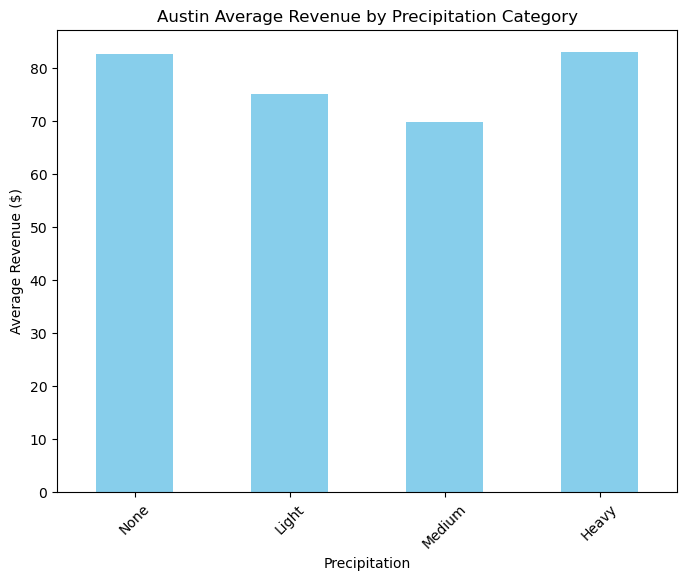

In [208]:
#Visualize the Revenue by precipation data

plt.figure(figsize=(8, 6))
revenue_by_precipitation.plot(kind='bar', color='skyblue')
plt.xlabel('Precipitation')
plt.ylabel('Average Revenue ($)')
plt.title('Austin Average Revenue by Precipitation Category')
plt.xticks(rotation=45)
plt.show()

In [97]:
#Correlate the data by precipitation category utilizing Total revenue, Ride time, and Ride Miles)
austin_correlation_by_precipitation_type = austin_cleaned.groupby('precipitation_category')[['total_revenue', 'total_ride_time_minutes', 'ride_miles']].corr()
print(austin_correlation_by_precipitation_type)

                                                total_revenue  \
precipitation_category                                          
None                   total_revenue                 1.000000   
                       total_ride_time_minutes       0.730790   
                       ride_miles                    0.844857   
Light                  total_revenue                 1.000000   
                       total_ride_time_minutes       0.630205   
                       ride_miles                    0.824573   
Medium                 total_revenue                 1.000000   
                       total_ride_time_minutes       0.421122   
                       ride_miles                    0.406531   
Heavy                  total_revenue                 1.000000   
                       total_ride_time_minutes       0.651219   
                       ride_miles                    0.818279   

                                                total_ride_time_minutes  \
precipitation_

C:\Users\jchay\AppData\Local\Temp\ipykernel_6832\837665552.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  austin_correlation_by_precipitation_type = austin_cleaned.groupby('precipitation_category')[['total_revenue', 'total_ride_time_minutes', 'ride_miles']].corr()


In [98]:
   # Calculate Revenue per mile
austin_cleaned['revenue_per_mile'] = austin_cleaned['total_revenue'] / austin_cleaned['ride_miles']   
austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_mile
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,None,0.0,7.846154
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,None,0.0,25.689655
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,None,0.0,15.014041
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,None,0.0,16.800000
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,None,0.0,55.312057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,19.808500,0.0,0.0,0.0,100.0,8.375320,9.0,0.0,None,0.0,31.769231
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,19.808500,0.0,0.0,0.0,100.0,8.375320,21.0,0.0,None,0.0,29.129630
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,19.808500,0.0,0.0,0.0,100.0,8.375320,7.0,0.0,None,0.0,23.223022
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,19.808500,0.0,0.0,0.0,100.0,8.375320,12.0,0.0,None,0.0,26.807512


In [99]:
#Group by percipiation category and calulate the mean revenue per mile

austin_revenue_per_mile = austin_cleaned.groupby('precipitation_category')['revenue_per_mile'].mean().reset_index()

C:\Users\jchay\AppData\Local\Temp\ipykernel_6832\4192966616.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  austin_revenue_per_mile = austin_cleaned.groupby('precipitation_category')['revenue_per_mile'].mean().reset_index()


In [101]:
#Create Revenue by minute

austin_cleaned['revenue_per_minute'] = austin_cleaned['total_revenue'] / austin_cleaned['total_ride_time_minutes']
austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_mile,revenue_per_minute
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,None,0.0,7.846154,7.820000
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,None,0.0,25.689655,1.798276
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,None,0.0,15.014041,7.403077
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,None,0.0,16.800000,5.628000
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,None,0.0,55.312057,15.598000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,19.808500,0.0,0.0,0.0,100.0,8.375320,9.0,0.0,None,0.0,31.769231,9.177778
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,19.808500,0.0,0.0,0.0,100.0,8.375320,21.0,0.0,None,0.0,29.129630,2.996190
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,19.808500,0.0,0.0,0.0,100.0,8.375320,7.0,0.0,None,0.0,23.223022,4.611429
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,19.808500,0.0,0.0,0.0,100.0,8.375320,12.0,0.0,None,0.0,26.807512,4.758333


C:\Users\jchay\AppData\Local\Temp\ipykernel_6832\1762332546.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='precipitation_category', y='revenue_per_minute', data=austin_cleaned, palette='Blues')


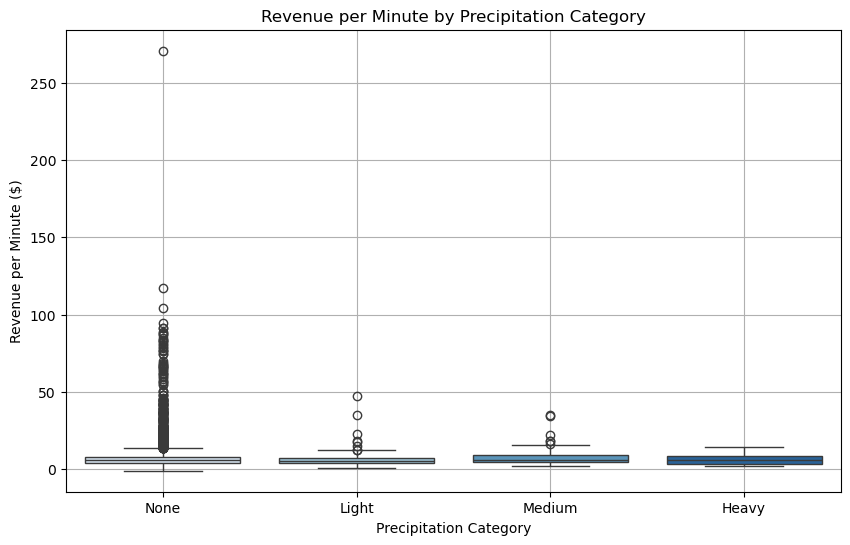

In [102]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='precipitation_category', y='revenue_per_minute', data=austin_cleaned, palette='Blues')
plt.xlabel('Precipitation Category')
plt.ylabel('Revenue per Minute ($)')
plt.title('Revenue per Minute by Precipitation Category')
plt.grid(True)

plt.show()

C:\Users\jchay\AppData\Local\Temp\ipykernel_6832\1386585965.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = austin_cleaned.pivot_table(index='hour', columns='precipitation_category', values='revenue_per_minute', aggfunc='mean')


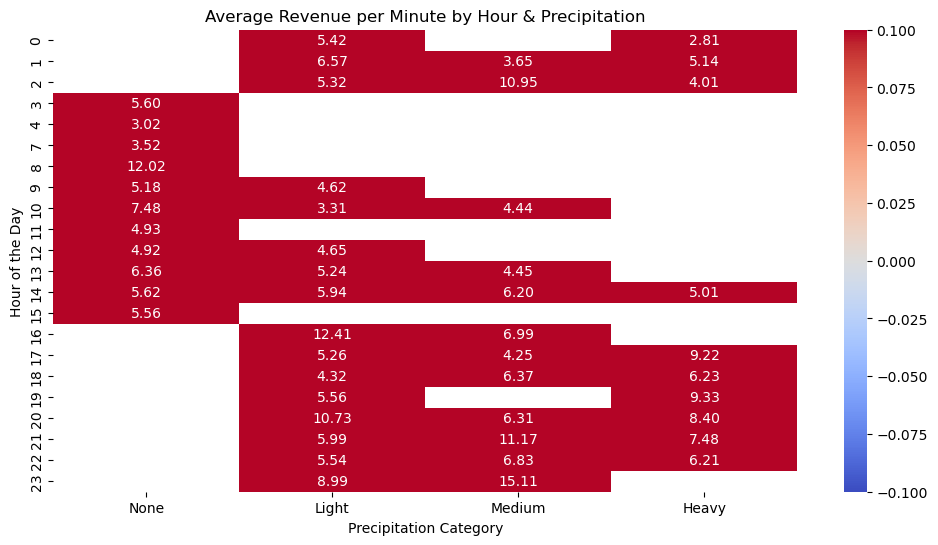

In [103]:
austin_cleaned['hour'] = austin_cleaned['ride_start_date_time_converted'].dt.hour

# Pivot table for heatmap
heatmap_data = austin_cleaned.pivot_table(index='hour', columns='precipitation_category', values='revenue_per_minute', aggfunc='mean')

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")

plt.xlabel('Precipitation Category')
plt.ylabel('Hour of the Day')
plt.title('Average Revenue per Minute by Hour & Precipitation')
plt.show()

In [104]:
#Add Revenue per mile
austin_cleaned['revenue_per_mile'] = austin_cleaned['total_revenue'] / austin_cleaned['ride_miles']   
austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_mile,revenue_per_minute,hour
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,None,0.0,7.846154,7.820000,0
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,None,0.0,25.689655,1.798276,1
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,None,0.0,15.014041,7.403077,1
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,None,0.0,16.800000,5.628000,1
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,None,0.0,55.312057,15.598000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,19.808500,0.0,0.0,0.0,100.0,8.375320,9.0,0.0,None,0.0,31.769231,9.177778,21
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,19.808500,0.0,0.0,0.0,100.0,8.375320,21.0,0.0,None,0.0,29.129630,2.996190,17
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,19.808500,0.0,0.0,0.0,100.0,8.375320,7.0,0.0,None,0.0,23.223022,4.611429,17
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,19.808500,0.0,0.0,0.0,100.0,8.375320,12.0,0.0,None,0.0,26.807512,4.758333,19


In [105]:
print(austin_cleaned.isnull().sum())

age_surge_charge                  0
total_revenue                     0
ride_miles                        0
ride_start_date_time_converted    0
ride_end_date_time_converted      0
temperature_2m                    0
precipitation                     0
rain                              0
snowfall                          0
cloud_cover                       0
wind_speed_10m                    0
total_ride_time_minutes           0
total_precipitation               0
precipitation_category            0
log_total_precipitation           0
revenue_per_mile                  0
revenue_per_minute                0
hour                              0
dtype: int64


In [106]:
print(austin_cleaned.dtypes)

age_surge_charge                           int64
total_revenue                            float64
ride_miles                               float64
ride_start_date_time_converted    datetime64[ns]
ride_end_date_time_converted      datetime64[ns]
temperature_2m                           float32
precipitation                            float32
rain                                     float32
snowfall                                 float32
cloud_cover                              float32
wind_speed_10m                           float32
total_ride_time_minutes                  float64
total_precipitation                      float32
precipitation_category                  category
log_total_precipitation                  float32
revenue_per_mile                         float64
revenue_per_minute                       float64
hour                                       int32
dtype: object


In [107]:
# Convert categorical columns to numeric codes
austin_cleaned['precipitation_category'] = austin_cleaned['precipitation_category'].cat.codes

# Check for missing values
print(austin_cleaned.isnull().sum())

# Drop or fill missing values
austin_cleaned = austin_cleaned.dropna()

age_surge_charge                  0
total_revenue                     0
ride_miles                        0
ride_start_date_time_converted    0
ride_end_date_time_converted      0
temperature_2m                    0
precipitation                     0
rain                              0
snowfall                          0
cloud_cover                       0
wind_speed_10m                    0
total_ride_time_minutes           0
total_precipitation               0
precipitation_category            0
log_total_precipitation           0
revenue_per_mile                  0
revenue_per_minute                0
hour                              0
dtype: int64


In [108]:
# Change precipitation category to numerical values
austin_cleaned['precipitation_category'] = austin_cleaned['precipitation_category'].astype('category').cat.codes
austin_cleaned.head()

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_mile,revenue_per_minute,hour
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,0,0.0,7.846154,7.820000,0
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,0,0.0,25.689655,1.798276,1
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,0,0.0,15.014041,7.403077,1
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,0,0.0,16.800000,5.628000,1
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,0,0.0,55.312057,15.598000,1


In [109]:

# Convert total_revenue into categories
austin_cleaned['revenue_category'] = pd.qcut(austin_cleaned['total_revenue'], q=3, labels=[0, 1, 2])
austin_cleaned.head()

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_mile,revenue_per_minute,hour,revenue_category
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,0,0.0,7.846154,7.820000,0,2
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,0,0.0,25.689655,1.798276,1,0
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,0,0.0,15.014041,7.403077,1,2
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,0,0.0,16.800000,5.628000,1,1
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,0,0.0,55.312057,15.598000,1,1


In [110]:

# Drop rows with NaN values after binning
austin_cleaned = austin_cleaned.dropna(subset=['revenue_category'])
austin_cleaned.head()

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_mile,revenue_per_minute,hour,revenue_category
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,0,0.0,7.846154,7.820000,0,2
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,0,0.0,25.689655,1.798276,1,0
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,0,0.0,15.014041,7.403077,1,2
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,0,0.0,16.800000,5.628000,1,1
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,0,0.0,55.312057,15.598000,1,1


In [111]:

# Define features (X) and target (y)
X = austin_cleaned[['revenue_per_mile', 'revenue_per_minute', 'precipitation_category']]
y = austin_cleaned['revenue_category']

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.head()

C:\Users\jchay\AppData\Local\Temp\ipykernel_6832\383592710.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)


,revenue_per_mile,revenue_per_minute,precipitation_category
0,7.846154,7.820000,0
1,25.689655,1.798276,0
2,15.014041,7.403077,0
3,16.800000,5.628000,0
4,55.312057,15.598000,0


In [112]:

# Check if NaNs exist and remove them
X = X.dropna()
y = y.loc[X.index]  

# Clip extreme values
X = X.clip(lower=X.quantile(0.01), upper=X.quantile(0.99), axis=1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.62
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.67      0.66       511
           1       0.54      0.53      0.54       463
           2       0.65      0.65      0.65       509

    accuracy                           0.62      1483
   macro avg       0.62      0.62      0.62      1483
weighted avg       0.62      0.62      0.62      1483



In [113]:
austin_cleaned

,age_surge_charge,total_revenue,ride_miles,ride_start_date_time_converted,ride_end_date_time_converted,temperature_2m,precipitation,rain,snowfall,cloud_cover,wind_speed_10m,total_ride_time_minutes,total_precipitation,precipitation_category,log_total_precipitation,revenue_per_mile,revenue_per_minute,hour,revenue_category
0,1,93.84,11.96,2024-01-01 00:48:00,2024-01-01 01:00:00,15.408501,0.0,0.0,0.0,0.0,10.594036,12.0,0.0,0,0.0,7.846154,7.820000,0,2
1,0,52.15,2.03,2024-01-01 01:00:00,2024-01-01 01:29:00,18.108500,0.0,0.0,0.0,0.0,4.896530,29.0,0.0,0,0.0,25.689655,1.798276,1,0
2,0,96.24,6.41,2024-01-01 01:21:00,2024-01-01 01:34:00,18.108500,0.0,0.0,0.0,0.0,4.896530,13.0,0.0,0,0.0,15.014041,7.403077,1,2
3,0,56.28,3.35,2024-01-01 01:50:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,10.0,0.0,0,0.0,16.800000,5.628000,1,1
4,0,77.99,1.41,2024-01-01 01:55:00,2024-01-01 02:00:00,18.108500,0.0,0.0,0.0,0.0,4.896530,5.0,0.0,0,0.0,55.312057,15.598000,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7444,0,82.60,2.60,2025-03-03 21:24:00,2025-03-03 21:33:00,19.808500,0.0,0.0,0.0,100.0,8.375320,9.0,0.0,0,0.0,31.769231,9.177778,21,2
7445,0,62.92,2.16,2025-03-04 17:45:00,2025-03-04 18:06:00,19.808500,0.0,0.0,0.0,100.0,8.375320,21.0,0.0,0,0.0,29.129630,2.996190,17,1
7446,0,32.28,1.39,2025-03-04 17:56:00,2025-03-04 18:03:00,19.808500,0.0,0.0,0.0,100.0,8.375320,7.0,0.0,0,0.0,23.223022,4.611429,17,0
7447,0,57.10,2.13,2025-03-04 19:23:00,2025-03-04 19:35:00,19.808500,0.0,0.0,0.0,100.0,8.375320,12.0,0.0,0,0.0,26.807512,4.758333,19,1


In [114]:
# Save austin_cleaned DataFrame as a CSV file
austin_cleaned.to_csv("austin_cleaned.csv", index=False)

In [115]:
#Create DF with only Date and Revenue

austin_prophet = austin_cleaned[["ride_start_date_time_converted", "total_revenue"]]
austin_prophet.head()

,ride_start_date_time_converted,total_revenue
0,2024-01-01 00:48:00,93.84
1,2024-01-01 01:00:00,52.15
2,2024-01-01 01:21:00,96.24
3,2024-01-01 01:50:00,56.28
4,2024-01-01 01:55:00,77.99


In [116]:
#Rename Columns

austin_prophet.columns=['ds', 'y']
austin_prophet

,ds,y
0,2024-01-01 00:48:00,93.84
1,2024-01-01 01:00:00,52.15
2,2024-01-01 01:21:00,96.24
3,2024-01-01 01:50:00,56.28
4,2024-01-01 01:55:00,77.99
...,...,...
7444,2025-03-03 21:24:00,82.60
7445,2025-03-04 17:45:00,62.92
7446,2025-03-04 17:56:00,32.28
7447,2025-03-04 19:23:00,57.10


In [117]:
#Create Prophet model

austin_prophet_model = Prophet()

In [118]:
#Fit time series model
austin_prophet_model.fit(austin_prophet)

14:22:20 - cmdstanpy - INFO - Chain [1] start processing
14:22:22 - cmdstanpy - INFO - Chain [1] done processing


In [119]:
#Create a future data frame to hold predictions
future_austin_prophet = austin_prophet_model.make_future_dataframe(periods=2000, freq='H')
display(future_austin_prophet.head())
display(future_austin_prophet.tail())

c:\Users\jchay\anaconda3\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dates = pd.date_range(


,ds
0,2024-01-01 00:48:00
1,2024-01-01 01:00:00
2,2024-01-01 01:21:00
3,2024-01-01 01:50:00
4,2024-01-01 01:55:00


,ds
9206,2025-05-27 00:22:00
9207,2025-05-27 01:22:00
9208,2025-05-27 02:22:00
9209,2025-05-27 03:22:00
9210,2025-05-27 04:22:00


In [120]:
#Make Predictions for future Austin Revenue
forecast_austin_revenue = austin_prophet_model.predict(future_austin_prophet)
display(forecast_austin_revenue.head())
display(forecast_austin_revenue.tail())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2024-01-01 00:48:00,89.778996,-1.229630,114.572151,89.778996,89.778996,-29.742476,-29.742476,-29.742476,-31.683345,-31.683345,-31.683345,1.940869,1.940869,1.940869,0.0,0.0,0.0,60.036521
1,2024-01-01 01:00:00,89.778936,5.531924,116.132003,89.778936,89.778936,-29.794769,-29.794769,-29.794769,-31.638505,-31.638505,-31.638505,1.843736,1.843736,1.843736,0.0,0.0,0.0,59.984167
2,2024-01-01 01:21:00,89.778829,5.237167,123.371492,89.778829,89.778829,-29.976339,-29.976339,-29.976339,-31.649981,-31.649981,-31.649981,1.673642,1.673642,1.673642,0.0,0.0,0.0,59.802490
3,2024-01-01 01:50:00,89.778682,-0.565155,116.458946,89.778682,89.778682,-30.611930,-30.611930,-30.611930,-32.050777,-32.050777,-32.050777,1.438847,1.438847,1.438847,0.0,0.0,0.0,59.166752
4,2024-01-01 01:55:00,89.778656,-2.440849,119.170533,89.778656,89.778656,-30.777197,-30.777197,-30.777197,-32.175607,-32.175607,-32.175607,1.398410,1.398410,1.398410,0.0,0.0,0.0,59.001460


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
9206,2025-05-27 00:22:00,68.003754,-24.745896,91.823535,60.767610,75.501953,-33.845877,-33.845877,-33.845877,-31.734821,-31.734821,-31.734821,-2.111056,-2.111056,-2.111056,0.0,0.0,0.0,34.157878
9207,2025-05-27 01:22:00,67.996640,-29.374028,94.106526,60.753028,75.502290,-33.455747,-33.455747,-33.455747,-31.655304,-31.655304,-31.655304,-1.800443,-1.800443,-1.800443,0.0,0.0,0.0,34.540893
9208,2025-05-27 02:22:00,67.989526,-21.761970,94.185117,60.738445,75.502627,-34.563636,-34.563636,-34.563636,-33.102281,-33.102281,-33.102281,-1.461354,-1.461354,-1.461354,0.0,0.0,0.0,33.425891
9209,2025-05-27 03:22:00,67.982413,-32.162818,89.689232,60.720205,75.502963,-36.136941,-36.136941,-36.136941,-35.039105,-35.039105,-35.039105,-1.097836,-1.097836,-1.097836,0.0,0.0,0.0,31.845471
9210,2025-05-27 04:22:00,67.975299,-22.749920,93.545456,60.701484,75.503300,-31.158877,-31.158877,-31.158877,-30.444677,-30.444677,-30.444677,-0.714200,-0.714200,-0.714200,0.0,0.0,0.0,36.816422


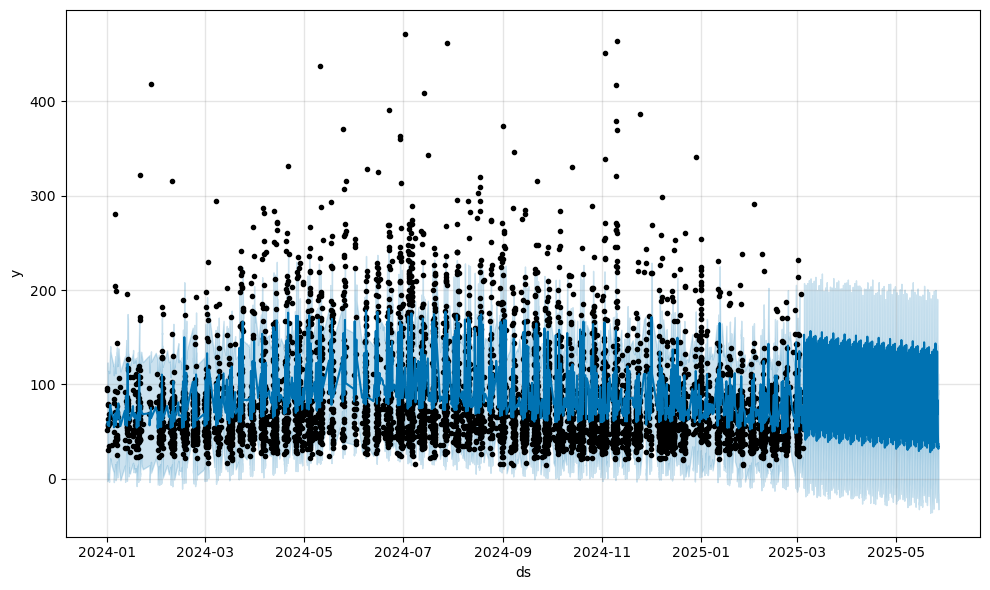

In [121]:
#Visualize Prophet model
austin_future_rev_graphs = austin_prophet_model.plot(forecast_austin_revenue)

In [122]:
#Create a DF for the logistic Regression model

austin_lr_df = austin_cleaned.copy()

In [123]:
#Convert datetime column

austin_lr_df['ride_start_date_time_converted'] = pd.to_datetime(austin_lr_df['ride_start_date_time_converted'])

In [124]:
#Create time features for Hours, day of week, and weekend

austin_lr_df['hour'] = austin_lr_df['ride_start_date_time_converted'].dt.hour
austin_lr_df['day_of_week'] = austin_lr_df['ride_start_date_time_converted'].dt.dayofweek  # Monday=0, Sunday=6
austin_lr_df['is_weekend'] = (austin_lr_df['day_of_week'] >= 5).astype(int)  # Weekend = 1

In [125]:
#Define Y which is high demand rides
austin_lr_df['high_value'] = np.where(austin_lr_df['total_revenue'] > austin_lr_df['total_revenue'].median(), 1, 0)

In [126]:
#Define Weather and time Features

features = [
    'temperature_2m', 'precipitation', 'rain', 'snowfall', 'cloud_cover',
    'wind_speed_10m', 'total_ride_time_minutes', 'ride_miles', 'hour', 'is_weekend'
]

In [127]:
#Convert category Variables into numerical Values

austin_lr_df = pd.get_dummies(austin_lr_df, drop_first=True)

In [128]:
#Define X & Y
X = austin_lr_df[features]
y = austin_lr_df['high_value']

In [129]:
#Split Data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
#Scale Data

austin_lr_scaler = StandardScaler()
X_train = austin_lr_scaler.fit_transform(X_train)
X_test = austin_lr_scaler.transform(X_test)


In [131]:
#fit the model

austin_lr_model = LogisticRegression()
austin_lr_model.fit(X_train, y_train)

LogisticRegression()

In [132]:
#Make Predictions

y_pred = austin_lr_model.predict(X_test)

In [133]:
#Step 12: Evaluate Model
print("Ride Value Prediction Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Ride Value Prediction Accuracy: 0.7053691275167785

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.84      0.74       736
           1       0.79      0.57      0.66       754

    accuracy                           0.71      1490
   macro avg       0.72      0.71      0.70      1490
weighted avg       0.72      0.71      0.70      1490



In [134]:
#Optimize the model by understanding peak hours and prediciting revenue off high demand times

In [135]:
#Extract hour from ride start time
austin_cleaned['hour'] = austin_cleaned['ride_start_date_time_converted'].dt.hour

In [136]:
#Define Ride counts in an hour

ride_counts_per_hour = austin_cleaned.groupby('hour').size().reset_index(name='ride_count')

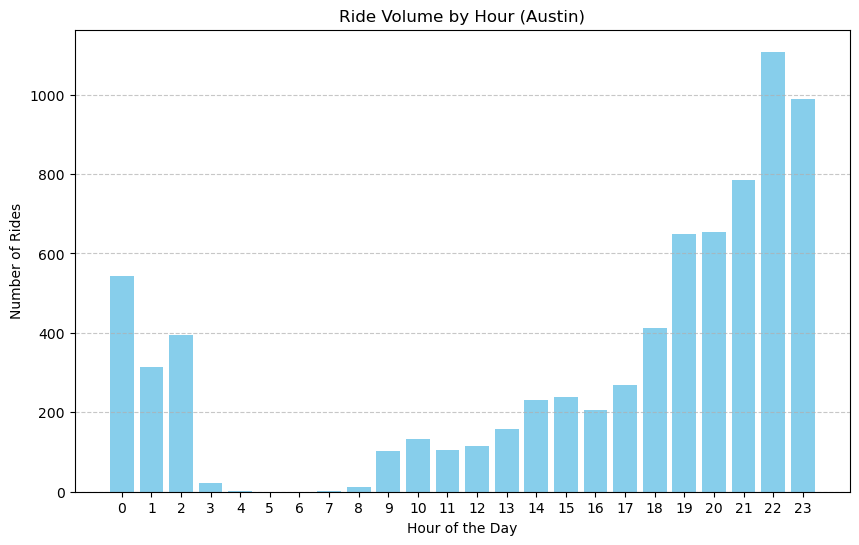

In [137]:
# Plot ride frequency by hour
plt.figure(figsize=(10,6))
plt.bar(ride_counts_per_hour['hour'], ride_counts_per_hour['ride_count'], color='skyblue')
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Rides")
plt.title("Ride Volume by Hour (Austin)")
plt.xticks(range(0, 24)) 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# #Chart was displaying without all hours on X Axis Need to fix
all_hours = pd.DataFrame({'hour': np.arange(24)})  
ride_counts_per_hour = all_hours.merge(ride_counts_per_hour, on='hour', how='left').fillna(0)  

In [229]:
# Format hours for x-axis labels
time_labels = [f"{h}:00" for h in ride_counts_per_hour['hour']]

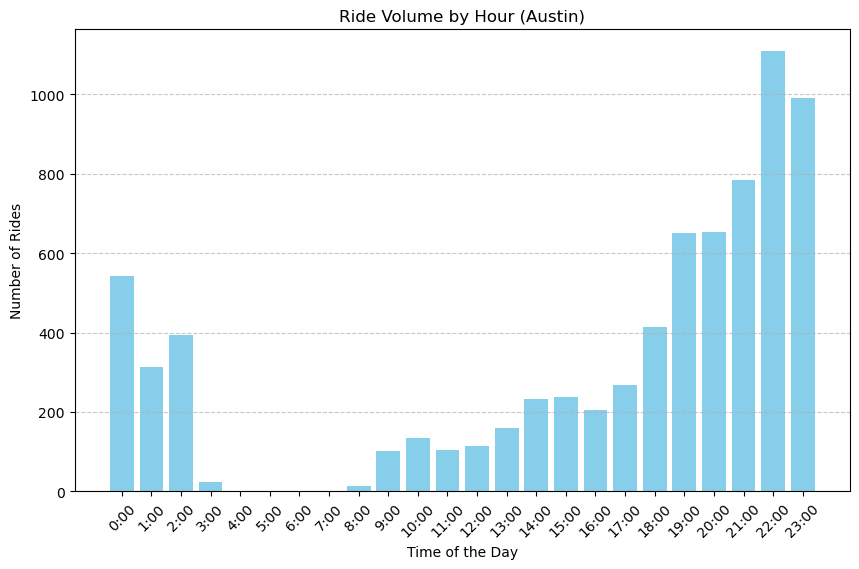

In [230]:
# Plot ride frequency by hour with time labels
plt.figure(figsize=(10,6))
plt.bar(ride_counts_per_hour['hour'], ride_counts_per_hour['ride_count'], color='skyblue')
plt.xlabel("Time of the Day")
plt.ylabel("Number of Rides")
plt.title("Ride Volume by Hour (Austin)")
plt.xticks(ride_counts_per_hour['hour'], time_labels, rotation=45)  # Ensure all labels show
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [140]:
#Define Rush hour rides from 7Pm to 1AM

austin_cleaned['rush_hour_ride'] = ((austin_cleaned['hour'] >= 17) | (austin_cleaned['hour'] <= 2))

                                 

In [141]:
# Convert boolean values to integers (1 = rush hour, 0 = non-rush hour)
austin_cleaned['rush_hour_ride'] = austin_cleaned['rush_hour_ride'].astype(int)


In [142]:
print(austin_cleaned[['hour', 'rush_hour_ride']].head(10))

   hour  rush_hour_ride
0     0               1
1     1               1
2     1               1
3     1               1
4     1               1
5     2               1
6     2               1
7     2               1
8     2               1
9     2               1


In [143]:
#Add Rush hour Ride into the Model

features = [
    'temperature_2m', 'precipitation', 'rain', 'snowfall', 'cloud_cover',
    'wind_speed_10m', 'total_ride_time_minutes', 'ride_miles', 'hour',
    'rush_hour_ride'
]

In [144]:
# Define target variable (high demand based on total revenue)
austin_cleaned['high_demand'] = np.where(
    austin_cleaned['total_revenue'] > austin_cleaned['total_revenue'].median(), 1, 0
)

In [145]:
# Define target variable 
austin_cleaned['high_revenue'] = np.where(
    austin_cleaned['total_revenue'] > austin_cleaned['total_revenue'].median(), 1, 0
)


In [146]:
# Prepare data for training
X = austin_cleaned[features]
y = austin_cleaned['high_revenue']

In [147]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [148]:
# Scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [149]:
# Train logistic regression model
austin_lr_model = LogisticRegression()
austin_lr_model.fit(X_train, y_train)

LogisticRegression()

In [150]:
# Make predictions
y_pred = austin_lr_model.predict(X_test)

In [151]:
# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification)

Model Accuracy: 0.71
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.84      0.74       736
           1       0.79      0.58      0.66       754

    accuracy                           0.71      1490
   macro avg       0.72      0.71      0.70      1490
weighted avg       0.72      0.71      0.70      1490



In [152]:
#Create a Random forest Model to predict Total revenue

In [153]:
features_rf = ["ride_miles", "temperature_2m", "precipitation", "rain", "snowfall",
            "cloud_cover", "wind_speed_10m", "total_ride_time_minutes", "hour", "rush_hour_ride"]
target_rf = "total_revenue"

In [154]:
X = austin_cleaned[features_rf]
y = austin_cleaned[target_rf]

In [155]:
# Split into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [156]:
# Train a Random Forest Regressor
austin_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
austin_rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [157]:
# Predictions
y_pred = austin_rf_model.predict(X_test)

In [158]:
# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error (MAE): 20.436474401565995
Root Mean Squared Error (RMSE): 26.85237364936503
R² Score: 0.7034723704292504


In [159]:
#Define X & y

X_tuned_rf = austin_cleaned[features_rf]
y_tuned_rf = austin_cleaned[target_rf]

In [160]:
#Split the data
X_trained_tuned, X_test_tuned, y_trained_tuned, y_test_tuned = train_test_split(X_tuned_rf, y_tuned_rf, test_size=0.2, random_state=42)

In [161]:
austin_rf_tuned = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    bootstrap=True,
    random_state=42
)

In [162]:
#Train the Optimized Model

austin_rf_tuned.fit(X_trained_tuned, y_trained_tuned)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, random_state=42)

In [163]:
#Make Predictions

y_pred_tuned = austin_rf_tuned.predict(X_test_tuned)

In [164]:
# Evaluate performance
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"Mean Absolute Error (MAE): {mae_tuned}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned}")
print(f"R² Score: {r2_tuned}")


Mean Absolute Error (MAE): 20.265091124899016
Root Mean Squared Error (RMSE): 26.629933624231928
R² Score: 0.7083647807391428


In [165]:
#Create Precipitation Categories

# Create 'precipitation_category' based on precipitation values
def categorize_precipitation(value):
    if value == 0:
        return 0  # None
    elif 0 < value <= 2:
        return 1  # Light
    elif 2 < value <= 5:
        return 2  # Medium
    else:
        return 3  # Heavy

austin_cleaned["precipitation_category"] = austin_cleaned["precipitation"].apply(categorize_precipitation)
austin_cleaned.value_counts("precipitation_category")

precipitation_category
0    6518
1     841
2      62
3      28
Name: count, dtype: int64

In [166]:
#Balance Data

austin_majority = austin_cleaned[austin_cleaned["precipitation_category"] == 0]  # 'None'
austin_light_precip = austin_cleaned[austin_cleaned["precipitation_category"] == 1]  # 'Light'
austin_medium_precip = austin_cleaned[austin_cleaned["precipitation_category"] == 2]  # 'Medium'
austin_heavy_precip = austin_cleaned[austin_cleaned["precipitation_category"] == 3]  # 'Heavy'


In [167]:
#Create Samples for underepresented data
austin_light_upsampled = resample(austin_light_precip, replace=True, n_samples=6518, random_state=42)
austin_medium_upsampled = resample(austin_medium_precip, replace=True, n_samples=6518, random_state=42)
austin_heavy_upsampled = resample(austin_heavy_precip, replace=True, n_samples=6518, random_state=42)


In [168]:
#create balanced DF for RF model
austin_balanced = pd.concat([austin_majority, austin_light_upsampled, austin_medium_upsampled, austin_heavy_upsampled])
austin_balanced = austin_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [169]:
austin_balanced.value_counts("precipitation_category")

precipitation_category
0    6518
1    6518
2    6518
3    6518
Name: count, dtype: int64

In [ ]:
# Select features and target
features_balanced = ["ride_miles", "total_ride_time_minutes", "hour", "rush_hour_ride", "precipitation_category"]
target_balanced = "total_revenue"

In [171]:
# Define X and y
X = austin_balanced[features_balanced]
y = austin_balanced[target_balanced]

In [172]:
# Split into training (80%) and testing (20%) sets
X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced = train_test_split(X, y, test_size=0.2, random_state=42)

In [173]:
# Manually tuned Random Forest model
rf_tuned_balanced = RandomForestRegressor(
    n_estimators=200, 
    max_depth=20,  
    min_samples_split=5,  
    min_samples_leaf=2,  
    bootstrap=True,  
    random_state=42
)

In [174]:
# Train the optimized model
rf_tuned_balanced.fit(X_train_balanced, y_train_balanced)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=200, random_state=42)

In [175]:
#Create Predictions
y_pred_balanced = rf_tuned_balanced.predict(X_test_balanced)
y_pred_balanced

array([70.6651333 , 25.05      , 80.52086858, ..., 64.77333375,
       52.23968783, 51.60292407])

In [176]:
# Evaluate performance
mae_tuned = mean_absolute_error(y_test_balanced, y_pred_balanced)
mse_tuned = mean_squared_error(y_test_balanced, y_pred_balanced)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test_balanced, y_pred_balanced)

# Print results
print(f"Mean Absolute Error (MAE): {mae_tuned}")
print(f"Root Mean Squared Error (RMSE): {rmse_tuned}")
print(f"R² Score: {r2_tuned}")

Mean Absolute Error (MAE): 6.381006823438642
Root Mean Squared Error (RMSE): 15.5788005686739
R² Score: 0.8902614864563764


In [177]:
from sklearn.ensemble import GradientBoostingRegressor

In [178]:
#Define Features for XGBoost model

features_xgboost = ["ride_miles", "total_ride_time_minutes", "hour", "rush_hour_ride", "precipitation_category"]
target_xgboost = "total_revenue"

In [179]:
# Define X and y
X_xgboost = austin_balanced[features_xgboost]
y_xgboost = austin_balanced[target_xgboost]


In [180]:
# Split into training (80%) and testing (20%) sets
X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(X_xgboost, y_xgboost, test_size=0.2, random_state=42)

In [181]:
# Train Gradient Boosting Regressor
austin_gb_model = GradientBoostingRegressor(
    n_estimators=200,  
    learning_rate=0.1, 
    max_depth=5,  
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

In [182]:
#Fit the model
austin_gb_model.fit(X_train_xgboost, y_train_xgboost)


GradientBoostingRegressor(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                          n_estimators=200, random_state=42)

In [183]:
# Predictions on test set
y_pred_gb = austin_gb_model.predict(X_test_xgboost)

In [184]:
# Evaluate performance
mae_gb = mean_absolute_error(y_test_xgboost, y_pred_gb)
mse_gb = mean_squared_error(y_test_xgboost, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test_xgboost, y_pred_gb)

# Print results
print(f"Mean Absolute Error (MAE): {mae_gb}")
print(f"Root Mean Squared Error (RMSE): {rmse_gb}")
print(f"R² Score: {r2_gb}")

Mean Absolute Error (MAE): 10.180328576036276
Root Mean Squared Error (RMSE): 17.546317487516855
R² Score: 0.8607923813314194


In [187]:
#Use Grid Search to determine best model

X_grid_search = austin_balanced[features_balanced]
y_grid_search = austin_balanced[target_balanced]

In [188]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_grid_search, y_grid_search, test_size=0.2, random_state=42)



In [189]:
# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [190]:
# Initialize Random Forest model
rf = RandomForestRegressor(random_state=42)

In [194]:
# Perform Grid Search
austin_grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='r2')
austin_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=1)

In [195]:
# Get the best model
austin_best_rf = austin_grid_search.best_estimator_

In [196]:
#Predictions on the test set

y_pred_best = austin_best_rf.predict(X_test)

In [198]:
# Evaluate performance
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
r2_best = r2_score(y_test, y_pred_best)

# Print results
print(f"Best Parameters: {austin_grid_search.best_params_}")
print(f"Mean Absolute Error (MAE): {mae_best}")
print(f"Root Mean Squared Error (RMSE): {rmse_best}")
print(f"R² Score: {r2_best}")

Best Parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Mean Absolute Error (MAE): 6.1036441213630575
Root Mean Squared Error (RMSE): 15.57859478312766
R² Score: 0.8902643855821085


In [205]:
#Save the RF Model for use in Atlanta

joblib.dump(austin_best_rf, "random_forest_revenue_model.pkl")

['random_forest_revenue_model.pkl']

In [207]:
print("Model saved as 'random_forest_revenue_model.pkl'")

Model saved as 'random_forest_revenue_model.pkl'


In [217]:
# Extract feature importance
austin_feature_importances = austin_best_rf.feature_importances_


In [ ]:

# Get feature names from the dataset
feature_names = X_train.columns  


In [219]:

# Combine into a DataFrame for easy viewing

austin_feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)


In [220]:

# Display feature importance values
print(austin_feature_importance_df)

                   Feature  Importance
0               ride_miles    0.813016
2                     hour    0.075276
1  total_ride_time_minutes    0.064095
4   precipitation_category    0.042548
3           rush_hour_ride    0.005065


In [221]:
# Sort the features by importance (descending order)
austin_feature_importance_df = austin_feature_importance_df.sort_values(by='Importance', ascending=False)

In [224]:
clean_labels = {
    'ride_miles': 'Ride Miles',
    'hour': 'Hour',
    'total_ride_time_minutes': 'Total Ride Time',
    'precipitation_category': 'Precipitation',
    'rush_hour_ride': 'Rush Hour Ride'
}

In [225]:
# Replace column names with cleaner labels

austin_feature_importance_df['Feature'] = austin_feature_importance_df['Feature'].map(clean_labels)

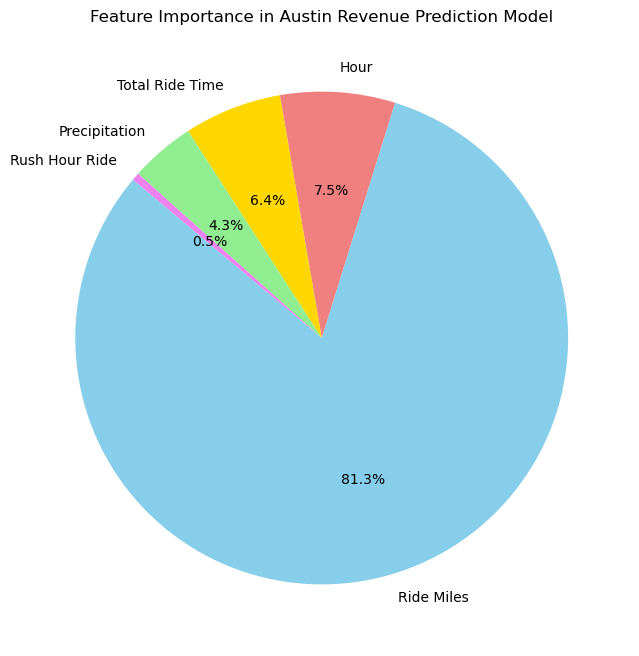

In [227]:
# Create a Pie Chart for Feature Importance
plt.figure(figsize=(8, 8))
plt.pie(
    austin_feature_importance_df['Importance'],
    labels= austin_feature_importance_df['Feature'],
    autopct='%1.1f%%',  # Format percentage labels
    startangle=140,
    colors=['skyblue', 'lightcoral', 'gold', 'lightgreen', 'violet']
)
plt.title('Feature Importance in Austin Revenue Prediction Model')

# Show the plot
plt.show()